Parameter Heatmap
==========

This tutorial will show how to optimize strategies with multiple parameters and how to examine and reason about optimization results.
It is assumed you're already familiar with
[basic _backtesting.py_ usage](https://kernc.github.io/backtesting.py/doc/examples/Quick Start User Guide.html).

First, let's again import our helper moving average function.
In practice, one should use functions from an indicator library, such as
[TA-Lib](https://github.com/mrjbq7/ta-lib) or
[Tulipy](https://tulipindicators.org).

In [1]:
from backtesting.test import SMA

Loading BokehJS ...

Our strategy will be a similar moving average cross-over strategy to the one in
[Quick Start User Guide](https://kernc.github.io/backtesting.py/doc/examples/Quick Start User Guide.html),
but we will use four moving averages in total:
two moving averages whose relationship determines a general trend
(we only trade long when the shorter MA is above the longer one, and vice versa),
and two moving averages whose cross-over with daily _close_ prices determine the signal to enter or exit the position.

In [2]:
from backtesting import Strategy
from backtesting.lib import crossover


class Sma4Cross(Strategy):
    n1 = 50
    n2 = 100
    n_enter = 20
    n_exit = 10
    
    def init(self):
        self.sma1 = self.I(SMA, self.data.Close, self.n1)
        self.sma2 = self.I(SMA, self.data.Close, self.n2)
        self.sma_enter = self.I(SMA, self.data.Close, self.n_enter)
        self.sma_exit = self.I(SMA, self.data.Close, self.n_exit)
        
    def next(self):
        
        if not self.position:
            
            # On upwards trend, if price closes above
            # "entry" MA, go long
            
            # Here, even though the operands are arrays, this
            # works by implicitly comparing the two last values
            if self.sma1 > self.sma2:
                if crossover(self.data.Close, self.sma_enter):
                    self.buy()
                    
            # On downwards trend, if price closes below
            # "entry" MA, go short
            
            else:
                if crossover(self.sma_enter, self.data.Close):
                    self.sell()
        
        # But if we already hold a position and the price
        # closes back below (above) "exit" MA, close the position
        
        else:
            if (self.position.is_long and
                crossover(self.sma_exit, self.data.Close)
                or
                self.position.is_short and
                crossover(self.data.Close, self.sma_exit)):
                
                self.position.close()

It's not a robust strategy, but we can optimize it. Let's optimize our strategy on Google stock data.

In [3]:
%%time 

from backtesting import Backtest
from backtesting.test import GOOG


backtest = Backtest(GOOG, Sma4Cross, commission=.002)

stats, heatmap = backtest.optimize(
    n1=range(10, 110, 10),
    n2=range(20, 210, 20),
    n_enter=range(15, 35, 5),
    n_exit=range(10, 25, 5),
    constraint=lambda p: p.n_exit < p.n_enter < p.n1 < p.n2,
    maximize='Equity Final [$]',
    return_heatmap=True)

CPU times: user 316 ms, sys: 45.6 ms, total: 362 ms
Wall time: 13.2 s


Notice `return_heatmap=True` parameter passed to
[`Backtest.optimize()`](https://kernc.github.io/backtesting.py/doc/backtesting/backtesting.html#backtesting.backtesting.Backtest.optimize).
It makes the function return a heatmap series along with the usual stats of the best run.
`heatmap` is a pandas Series indexed with a MultiIndex, a cartesian product of all permissible parameter values.
The series values are from the `maximize=` argument we provided.

In [4]:
heatmap

n1   n2   n_enter  n_exit
20   40   15       10        8803.91
     60   15       10       10102.87
     80   15       10        9864.22
     100  15       10       11003.22
     120  15       10       12790.06
                              ...   
100  200  25       15        9549.19
                   20        8241.72
          30       10        9953.07
                   15        9701.12
                   20        7485.95
Length: 486, dtype: float64

This heatmap contains the results of all the runs,
making it very easy to obtain parameter combinations for e.g. three best runs:

In [5]:
heatmap.sort_values().iloc[-3:]

n1  n2   n_enter  n_exit
40  60   25       15       21014.63
50  120  20       15       21588.32
40  160  20       15       22418.30
dtype: float64

But we use vision to make judgements on larger data sets much faster.
Let's plot the whole heatmap by projecting it on two chosen dimensions.
Say we're mostly interested in how parameters `n1` and `n2`, on average, affect the outcome.

In [6]:
hm = heatmap.groupby(['n1', 'n2']).mean().unstack()
hm

n2,40,60,80,100,120,140,160,180,200
n1,,,,,,,,,
20,8803.91,10102.87,9864.22,11003.22,12790.06,12125.96,13291.88,9541.35,9981.48
30,11672.05,11888.46,12422.99,13201.24,12374.63,10968.28,12595.11,11002.74,10582.33
40,nan,14434.70,11311.47,8879.95,11234.82,9568.99,12591.88,10777.57,10112.56
50,nan,9275.58,10767.09,11796.92,11899.20,10052.85,11595.15,10766.80,9746.36
60,nan,nan,9935.79,11009.34,9583.58,10806.22,11361.59,10493.33,9655.29
70,nan,nan,11037.58,9447.27,9835.48,10758.90,11365.42,9992.12,8672.41
80,nan,nan,nan,10111.50,10226.34,10266.09,11116.05,10237.26,9539.06
90,nan,nan,nan,11176.47,11228.66,10263.17,11183.08,10523.47,10239.37
100,nan,nan,nan,nan,11964.01,9432.46,11700.69,10105.04,10540.90


Let's plot this table using the excellent [_Seaborn_](https://seaborn.pydata.org) package:

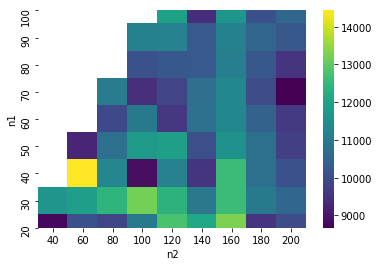

In [7]:
%matplotlib inline

import seaborn as sns


sns.heatmap(hm[::-1], cmap='viridis')

We see that, on average, we obtain the highest result using trend-determining parameters `n1=40` and `n2=60`,
and it's not like other nearby combinations work similarly well — in our particular strategy, this combination really stands out.

Since our strategy contains several parameters, we might be interested in other relationships between their values.
We can use
[`backtesting.lib.plot_heatmaps()`](https://kernc.github.io/backtesting.py/doc/backtesting/lib.html#backtesting.lib.plot_heatmaps)
function to plot interactive heatmaps of all parameter combinations simultaneously.

In [8]:
from backtesting.lib import plot_heatmaps


plot_heatmaps(heatmap, agg='mean')

Column(id='1252', ...)

Learn more by exploring further
[examples](https://kernc.github.io/backtesting.py/doc/backtesting/index.html#tutorials)
or find more framework options in the
[full API reference](https://kernc.github.io/backtesting.py/doc/backtesting/index.html#header-submodules).